# Program to visualize the solution space in noisy condition

In this program, we have modeled the noisy conditions of an actual quantum device of IBM and then try to visualize the solution space in these noisy conditions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import minimize

# for modeling noise
from qiskit_aer.noise import (
    NoiseModel,
    amplitude_damping_error,
    phase_damping_error,
    depolarizing_error,
    thermal_relaxation_error
)

from qiskit_aer import AerSimulator
from qiskit_optimization.applications import Maxcut
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator 
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


Defining the graph (problem) whose Maxcut value is to be calculated.

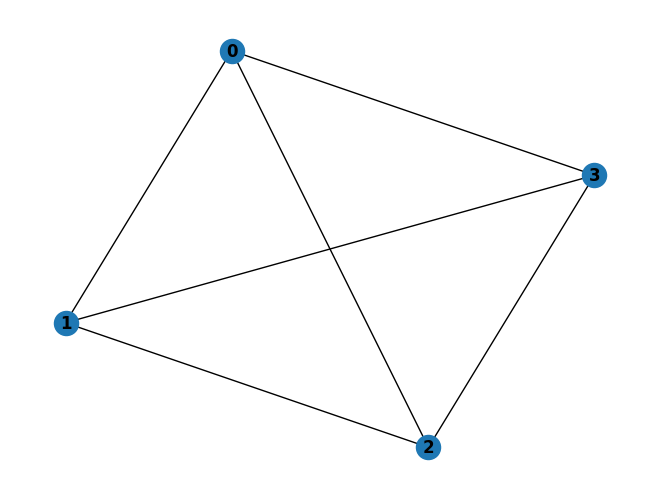

In [14]:

n = 4
p = 1
G = nx.erdos_renyi_graph(n, 1)
for (u,v) in G.edges():
    G[u][v]['weight'] = 1.0

edges = G.edges()
nx.draw(G, with_labels=True, font_weight='bold')
w = np.zeros([n,n])
for (u,v) in G.edges():
    w[u][v] = G[u][v]['weight']
    w[v][u] = G[u][v]['weight']
#print(w)


Converting the Classical Maxcut problem function (C(X)) into Cost Hamiltonian $<H_C>$. Note that there is a offset term, which shifts the energy landscape by this offset value. So make sure to add this offset value to the energy calculated at the end to find the actual energy.

In [15]:
prob=Maxcut(w)
qp = prob.to_quadratic_program()
print(qp.prettyprint())
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
print(qubo.prettyprint())

cost_hamiltonian, offset = qubo.to_ising()
print(offset)
print(cost_hamiltonian)

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_1*x_3 - 2*x_2*x_3 + 3*x_0
  + 3*x_1 + 3*x_2 + 3*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3

Problem name: Max-cut

Minimize
  2*x_0*x_1 + 2*x_0*x_2 + 2*x_0*x_3 + 2*x_1*x_2 + 2*x_1*x_3 + 2*x_2*x_3 - 3*x_0
  - 3*x_1 - 3*x_2 - 3*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3

-3.0
SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


function to calculate the expectation value of $H_C$ w.r.t. the state prepared by the quantum circuit

In [16]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    return cost

Actual errors of the IBM quantum device, ${\bf IBMQX4}$

In [17]:
# Coherence times (in nanoseconds)
T1 = 6*45e3  # relaxation time (amplitude damping error)
T2 = 7*20e3  # dephasing time (phase damping error)

# Time taken by different gates
u1 = 0.0  # RZ(gamma) gate (Virtual gate) 
u2 = 60  # Hadamard Gate
u3 = 120  # RX(beta) gate
cx = 720  # CNOT gate (2-qubit gate)

# gate error probability (Depolarizing Error)
err_1q = 1.5e-3  # 1-qubit gate error
err_2q = 4e-2  # 2-qubit gate error

Calculating total time taken in the quantum circuit execution

In [18]:
total_execution_time = (p*(len(edges)*cx*2+ n*u3)+ n*u2)                    
t = total_execution_time

Preparing circuit

In [19]:
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()

Defining the range of parameters to find the landscape

In [20]:
beta = np.linspace(0, 2*np.pi, 100)
gamma = np.linspace(0, 2*np.pi, 100)

Noise Model

In [ ]:
# T1 error
p_t1 = 1 - np.exp(-t / T1)  # amplitude damping error probability
error_t1 = amplitude_damping_error(p_t1)  # 1-qubit T1 error
error_t1_cx = amplitude_damping_error(p_t1).tensor(amplitude_damping_error(p_t1))  # 2-qubit T1 error

# T2 error
p_t2 = 1 - np.exp(-t / T2)  # phase damping error probability
error_t2 = phase_damping_error(p_t2)  # 1-qubit T2 error
error_t2_cx = phase_damping_error(p_t2).tensor(phase_damping_error(p_t2))  # 2-qubit T2 error

# gate error
error_1q = depolarizing_error(err_1q, num_qubits=1)  # 1-qubit gate error
error_2q = depolarizing_error(err_2q, num_qubits=2)  # 2-qubit gate error

error_1q_all = error_t1.compose(error_t2).compose(error_1q)  # combining all 1-qubit errors
error_2q_all = error_t1_cx.compose(error_t2_cx).compose(error_2q)  # combining all 2-qubit errors

# Noise Model
noise_all = NoiseModel()
noise_all.add_all_qubit_quantum_error(error_1q_all, ['u1', 'u2', 'u3'])  # 1-qubit error qate specifications
noise_all.add_all_qubit_quantum_error(error_2q_all, ['cx'])  # 2-qubit error gate specifications

# Creating the circuit by using Noisy gates as defined by the Noise Model
sim_all = AerSimulator(noise_model = noise_all)
pm1 = generate_preset_pass_manager(optimization_level=3,backend=sim_all)
candidate_circuit1 = pm1.run(circuit)

# 2D array to store the cost value for different $\beta$ and $\gamma$
AA = np.zeros([len(beta), len(gamma)])

for ii in range(0, len(beta), 1):
    for jj in range(0, len(gamma), 1):
        with Session(backend=sim_all) as session:  
            estimator = Estimator(mode=session)  
            estimator.options.default_shots = 100000  
            result1 = cost_func_estimator([beta[ii], gamma[jj]],
                                          candidate_circuit1, 
                                          cost_hamiltonian, 
                                          estimator)
        AA[jj][ii] = result1+offset  # adding offset to get the actual energy (cost)

Ideal Simulator (Noisefree)

In [22]:
sim_ideal = AerSimulator()
pm2 = generate_preset_pass_manager(optimization_level=3,backend=sim_ideal)
candidate_circuit2 = pm2.run(circuit)

BB = np.zeros([len(beta), len(gamma)])

for ii in range(0, len(beta), 1):
    for jj in range(0, len(gamma), 1):
        with Session(backend=sim_ideal) as session:  
            estimator = Estimator(mode=session)  
            estimator.options.default_shots = 100000  
            result2 = cost_func_estimator([beta[ii], gamma[jj]],
                                          candidate_circuit2, 
                                          cost_hamiltonian, 
                                          estimator)
        BB[jj][ii] = result2+offset

Plotting the Landscape

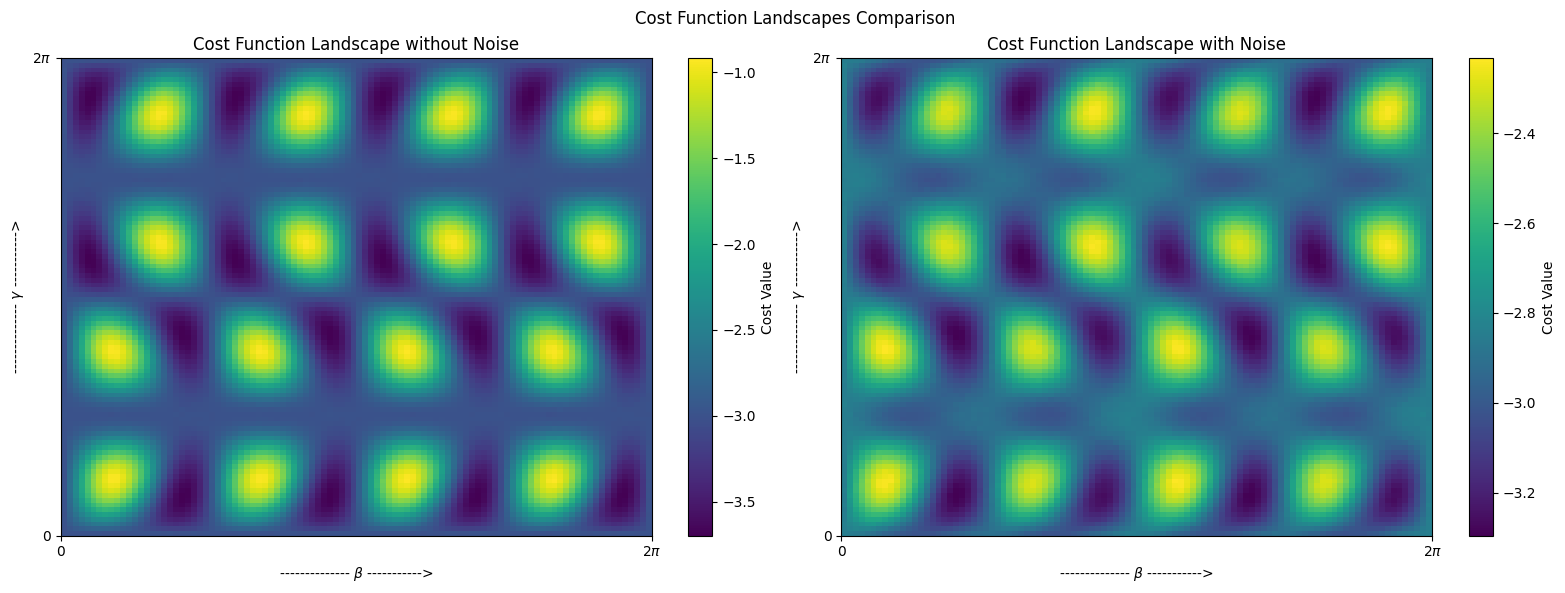

In [23]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

plt.tight_layout()
plt.imshow(BB, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Cost Value')
plt.xlabel('-------------- $\\beta$ ----------->')
plt.ylabel('-------------- $\\gamma$ ----------->')
plt.xticks([0, 2*np.pi], ['0', '2$\\pi$'])
plt.yticks([0, 2*np.pi], ['0', '2$\\pi$'])
plt.title('Cost Function Landscape without Noise')

plt.subplot(1, 2, 2)
plt.tight_layout()
plt.imshow(AA, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Cost Value')
plt.xlabel('-------------- $\\beta$ ----------->')
plt.ylabel('-------------- $\\gamma$ ----------->')
plt.title('Cost Function Landscape with Noise')
plt.suptitle('Cost Function Landscapes Comparison')
plt.xticks([0, 2*np.pi], ['0', '2$\\pi$'])
plt.yticks([0, 2*np.pi], ['0', '2$\\pi$'])
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.savefig('cost_function_landspace_modified_noise.pdf', dpi=300, bbox_inches='tight')
plt.show()